# Dimensionality Reduction: Mental Health in Tech 2016

## 1. Load Data & Scaling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('../data/processed/mental_health_preprocessed.csv')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

## 2. PCA (Principal Component Analysis)

In [2]:
from sklearn.decomposition import PCA

# Full PCA to analyze variance
pca_full = PCA()
pca_full.fit(X_scaled)

# Explained variance
exp_var = pca_full.explained_variance_ratio_
cum_var = np.cumsum(exp_var)

# Find components needed for 80% and 95% variance
n_80 = np.argmax(cum_var >= 0.80) + 1
n_95 = np.argmax(cum_var >= 0.95) + 1

print(f"Components for 80% variance: {n_80}")
print(f"Components for 95% variance: {n_95}")

Components for 80% variance: 49
Components for 95% variance: 80


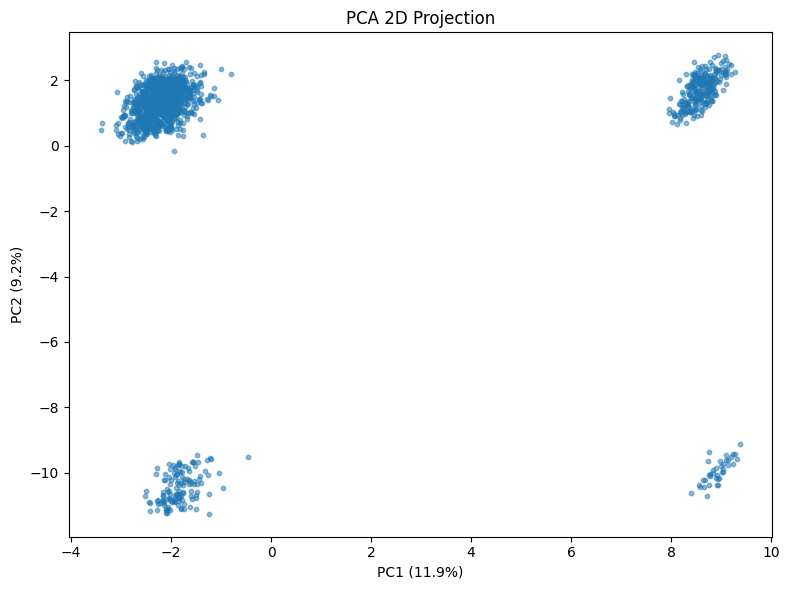

In [3]:
# 2D projection for visualization
pca_2d = PCA(n_components=2)
X_pca = pca_2d.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, s=10)
ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})')
ax.set_title('PCA 2D Projection')
plt.tight_layout()
plt.show()

In [4]:
# PCA preprocessing for downstream methods (50 components ≈ 80% variance)
pca_preprocessing = PCA(n_components=50)
X_pca_50 = pca_preprocessing.fit_transform(X_scaled)

## 3. MDS (Multidimensional Scaling)

In [5]:
from sklearn.manifold import MDS

# MDS on PCA-preprocessed data (50 components)
mds = MDS(n_components=2, random_state=42, n_jobs=-1, n_init=4, normalized_stress=True)
X_mds = mds.fit_transform(X_pca_50)

c:\Users\Sven-\OneDrive\Desktop\ML-UL-FE\venv\Lib\site-packages\sklearn\manifold\_mds.py:754: FutureWarning: The default value of `init` will change from 'random' to 'classical_mds' in 1.10. To suppress this warning, provide some value of `init`.
  warnings.warn(


## 4. LLE (Locally Linear Embedding)

In [6]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=15, random_state=42, n_jobs=-1)
X_lle = lle.fit_transform(X_pca_50)

## 5. t-SNE

In [7]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_jobs=-1)
X_tsne = tsne.fit_transform(X_pca_50)

## 6. UMAP

In [8]:
import umap

reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_pca_50)

c:\Users\Sven-\OneDrive\Desktop\ML-UL-FE\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## 7. Comparison

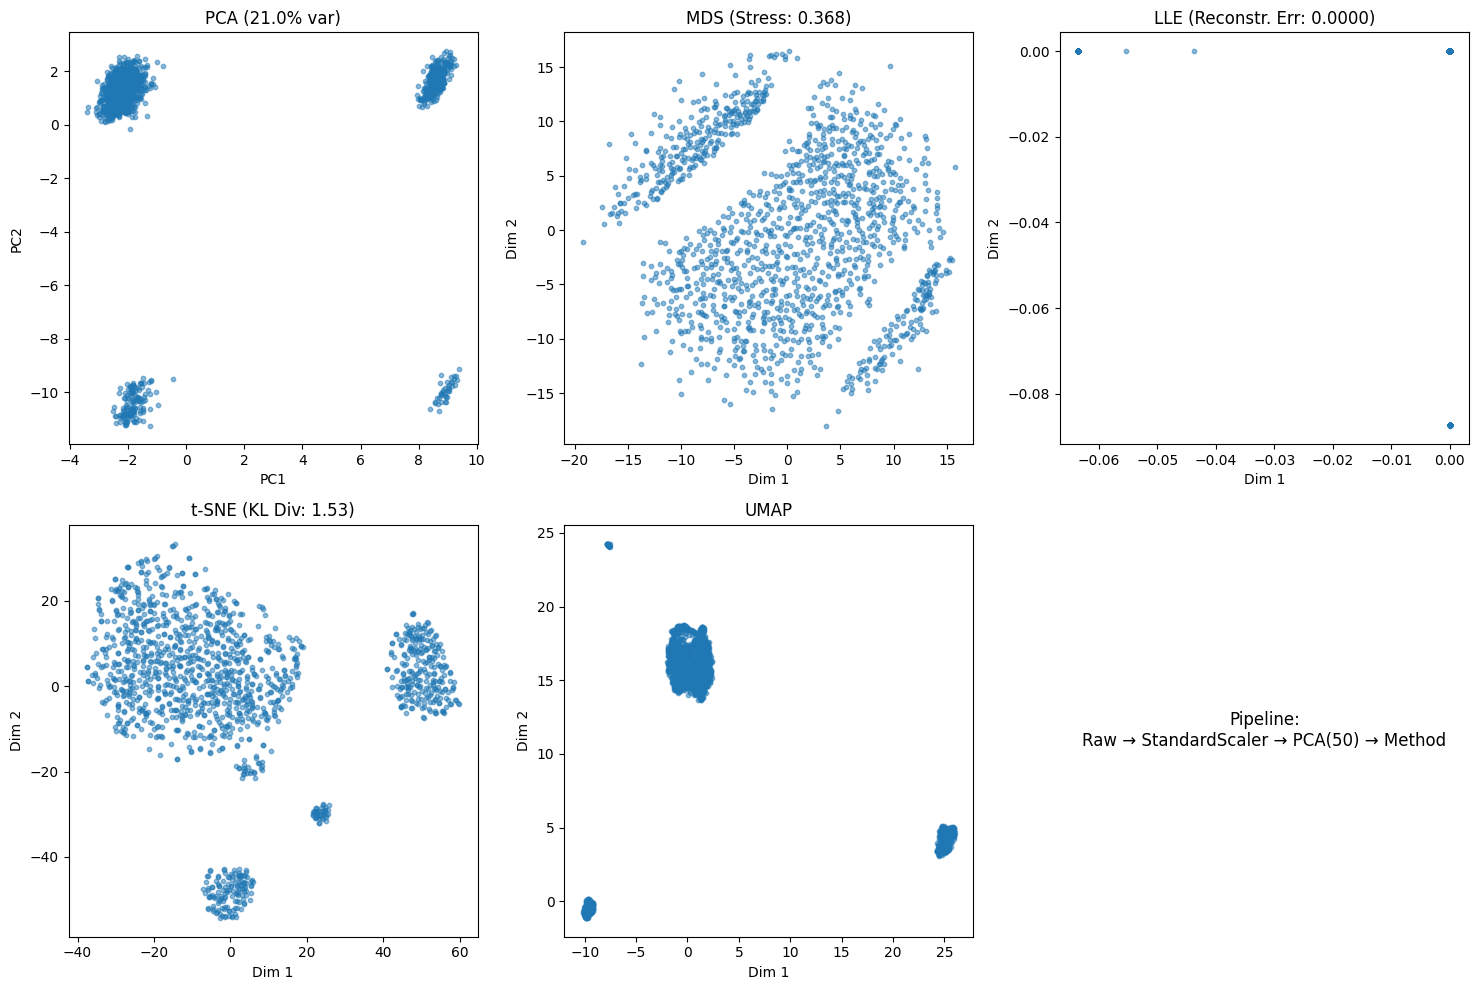

In [9]:
# Grid comparison of all methods
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# PCA
axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, s=10)
axes[0, 0].set_title(f'PCA ({pca_2d.explained_variance_ratio_.sum():.1%} var)')
axes[0, 0].set_xlabel('PC1')
axes[0, 0].set_ylabel('PC2')

# MDS
axes[0, 1].scatter(X_mds[:, 0], X_mds[:, 1], alpha=0.5, s=10)
axes[0, 1].set_title(f'MDS (Stress: {mds.stress_:.3f})')
axes[0, 1].set_xlabel('Dim 1')
axes[0, 1].set_ylabel('Dim 2')

# LLE
axes[0, 2].scatter(X_lle[:, 0], X_lle[:, 1], alpha=0.5, s=10)
axes[0, 2].set_title(f'LLE (Reconstr. Err: {lle.reconstruction_error_:.4f})')
axes[0, 2].set_xlabel('Dim 1')
axes[0, 2].set_ylabel('Dim 2')

# t-SNE
axes[1, 0].scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.5, s=10)
axes[1, 0].set_title(f't-SNE (KL Div: {tsne.kl_divergence_:.2f})')
axes[1, 0].set_xlabel('Dim 1')
axes[1, 0].set_ylabel('Dim 2')

# UMAP
axes[1, 1].scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.5, s=10)
axes[1, 1].set_title('UMAP')
axes[1, 1].set_xlabel('Dim 1')
axes[1, 1].set_ylabel('Dim 2')

# Empty subplot for text
axes[1, 2].axis('off')
axes[1, 2].text(0.5, 0.5, 'Pipeline:\nRaw → StandardScaler → PCA(50) → Method', 
                ha='center', va='center', fontsize=12, transform=axes[1, 2].transAxes)

plt.tight_layout()
plt.savefig('../plots/dimensionality_reduction_comparison.png', dpi=150)
plt.show()

## 8. Save Reduced Data

In [12]:
# Save all reduced datasets for clustering comparison
import os

output_dir = '../data/reduced'
os.makedirs(output_dir, exist_ok=True)

reduced_data = {
    'pca': X_pca,
    'mds': X_mds,
    'lle': X_lle,
    'tsne': X_tsne,
    'umap': X_umap
}

for name, data in reduced_data.items():
    df_reduced = pd.DataFrame(data, columns=['dim1', 'dim2'])
    df_reduced.to_csv(f'{output_dir}/{name}_2d.csv', index=False)